# Import

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import spacy
import re


# Setup

In [2]:
# Set seeds
np.random.seed(42)

# Read data

In [3]:
df_train = pd.read_csv('metastatic_local_train.csv', converters={'accept': literal_eval})
df_test = pd.read_csv("metastatic_local_test.csv", converters={'accept': literal_eval})

In [4]:
# Create dummy variables from accept column
df_train = df_train.join(pd.get_dummies(df_train["accept"].explode()).groupby(level=0).sum())
df_test = df_test.join(pd.get_dummies(df_test["accept"].explode()).groupby(level=0).sum())


# Dataset characteristics

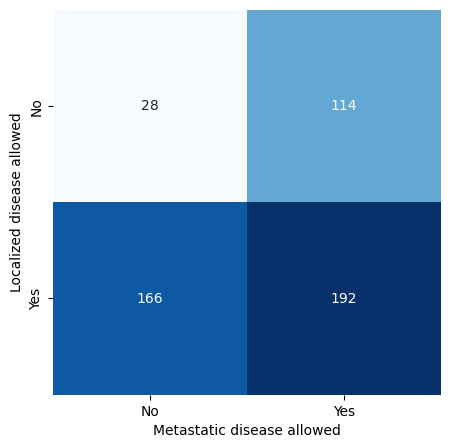

In [5]:
# Visualize the distribution of LOCAL and METASTATIC in the training set
fig = plt.figure(figsize=(5, 5))
train_cross_tab = pd.crosstab(df_train["LOCAL"], df_train["METASTATIC"])

sns.heatmap(train_cross_tab, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Metastatic disease allowed")
plt.ylabel("Localized disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/training_characteristics.png", dpi=300, bbox_inches="tight")

In [6]:
# Calculate percentages of respective fields in the training set

metastatic_and_local_train = 100 * train_cross_tab.loc[1, 1] / df_train.shape[0]
metastatic_not_local_train = 100 * train_cross_tab.loc[0, 1] / df_train.shape[0]
local_not_metastatic_train = 100 * train_cross_tab.loc[1, 0] / df_train.shape[0]
neither_train = 100 * train_cross_tab.loc[0, 0] / df_train.shape[0]

print(f"Percentage of trials that allow both metastatic and localized disease: {metastatic_and_local_train:.2f}%")
print(f"Percentage of trials that allow metastatic disease but not localized disease: {metastatic_not_local_train:.2f}%")
print(f"Percentage of trials that allow localized disease but not metastatic disease: {local_not_metastatic_train:.2f}%")
print(f"Percentage of trials that allow neither metastatic nor localized disease: {neither_train:.2f}%")

Percentage of trials that allow both metastatic and localized disease: 38.40%
Percentage of trials that allow metastatic disease but not localized disease: 22.80%
Percentage of trials that allow localized disease but not metastatic disease: 33.20%
Percentage of trials that allow neither metastatic nor localized disease: 5.60%


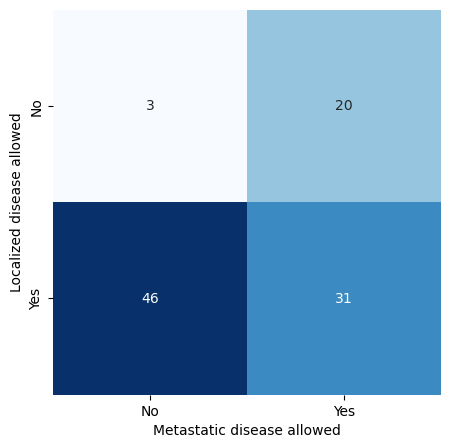

In [7]:
# Visualize the distribution of LOCAL and METASTATIC in the test set
fig = plt.figure(figsize=(5, 5))
test_cross_tab = pd.crosstab(df_test["LOCAL"], df_test["METASTATIC"])
sns.heatmap(test_cross_tab, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Metastatic disease allowed")
plt.ylabel("Localized disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/test_characteristics.png", dpi=300, bbox_inches="tight")

In [8]:
# Calculate percentages of respective fields in the test set

metastatic_and_local_test = 100 * test_cross_tab.loc[1, 1] / df_test.shape[0]
metastatic_not_local_test = 100 * test_cross_tab.loc[0, 1] / df_test.shape[0]
local_not_metastatic_test = 100 * test_cross_tab.loc[1, 0] / df_test.shape[0]
neither_test = 100 * test_cross_tab.loc[0, 0] / df_test.shape[0]

print(
    f"Percentage of trials that allow both metastatic and localized disease: {metastatic_and_local_test:.2f}%"
)
print(
    f"Percentage of trials that allow metastatic disease but not localized disease: {metastatic_not_local_test:.2f}%"
)
print(
    f"Percentage of trials that allow localized disease but not metastatic disease: {local_not_metastatic_test:.2f}%"
)
print(
    f"Percentage of trials that allow neither metastatic nor localized disease: {neither_test:.2f}%"
)

Percentage of trials that allow both metastatic and localized disease: 31.00%
Percentage of trials that allow metastatic disease but not localized disease: 20.00%
Percentage of trials that allow localized disease but not metastatic disease: 46.00%
Percentage of trials that allow neither metastatic nor localized disease: 3.00%


# Testing

## Make ML predictions

In [9]:
# Load model
metastatic_local_model = spacy.load("./metastatic_local_publication_v1/model-best")

/Users/paulwindisch/opt/anaconda3/envs/journal_nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Predict on the test set
def predict(text):
    prediction = metastatic_local_model(text)
    return prediction.cats

df_test["ML_prediction"] = df_test["text"].apply(predict)

# Create columns from the prediction dictionary
df_test["LOCAL_PREDICTED_ML"] = df_test["ML_prediction"].apply(
    lambda x: 1 if x["LOCAL"] > 0.5 else 0
)
df_test["METASTATIC_PREDICTED_ML"] = df_test["ML_prediction"].apply(
    lambda x: 1 if x["METASTATIC"] > 0.5 else 0
)

## Make regex predictions

In [11]:
def predict_metastatic_with_regex(title):
    title = title.lower()

    # Check for non-metastatic in the title
    if re.search(r"non[ -]?metast", title):
        return 0
    # Check for metastatic in the title
    if (
        re.search(r"metasta", title)
        and not re.search(r"non[- ]?metasta", title)
        and not re.search(r"metastas[ie]s[- ]free", title)
    ):
        return 1
    # Check for stage IV in the title
    if re.search(r"\biv\b", title):
        return 1
    # Check for stages other than IV in the title
    if (
        re.search(r"\bstage\b", title)
        and not (
            re.search(r"\biv", title)
            or re.search(r"extensive[- ]stage", title)
            or re.search(r"advanced[- ]stage", title)
            or re.search(r"\b4\b", title)
        )
    ):
        return 0
    # Check for advanced in the title
    if re.search(r"advanced", title) and not re.search(r"locally[- ]advanced", title):
        return 1
    # Check for extensive stage in the title
    if re.search(r"extensive[- ]stage", title):
        return 1
    # Make a random guess if none of the above conditions are met
    return np.random.choice([0, 1])


def predict_local_with_regex(title):
    title = title.lower()

    # Check for early breast and "or metastatic"
    if re.search(r"\bearly breast", title) or re.search(r"\bor metast", title):
        return 1

    # Check for stages other than IV
    if re.search(r"stage i[^v]", title):
        return 1

    # Check for non-metastatic
    if re.search(r"non[ -]?metast", title):
        return 1

    # Check for locally advanced
    if re.search(r"locally[- ]advanced", title) or re.search(r"locoregional", title):
        return 1
    # Make a random guess if none of the above conditions are met
    return np.random.choice([0, 1])


df_test["METASTATIC_PREDICTED_REGEX"] = df_test["title"].apply(predict_metastatic_with_regex)
df_test["LOCAL_PREDICTED_REGEX"] = df_test["title"].apply(predict_local_with_regex)

## Refine ML predictions with regex

In [12]:
def refine_metastatic_with_regex(row):
    title = row["title"].lower()
    # Check for non-metastatic in the title
    if row["METASTATIC_PREDICTED_ML"] == 1 and re.search(r"non[ -]?metast", title):
        return 0

    # Check for metastatic in the title
    if (
        row["METASTATIC_PREDICTED_ML"] == 0
        and re.search(r"metasta", title)
        and not re.search(r"non[- ]?metasta", title)
        and not re.search(r"metastas[ie]s[- ]free", title)
    ):
        return 1

    # Check for stage IV in the title
    if row["METASTATIC_PREDICTED_ML"] == 0 and re.search(r"\biv\b", title):
        return 1

    # Check for stages other than IV in the title
    if (
        row["METASTATIC_PREDICTED_ML"] == 1
        and re.search(r"\bstage\b", title)
        and not (
            re.search(r"\biv", title)
            or re.search(r"extensive[- ]stage", title)
            or re.search(r"advanced[- ]stage", title)
            or re.search(r"\b4\b", title)
        )
    ):
        return 0

    # Check for advanced in the title
    if row["METASTATIC_PREDICTED_ML"] == 0 and re.search(
        r"advanced", title
    ) and not re.search(r"locally[- ]advanced", title):
        return 1
    
    # Check for extensive stage in the title
    if row["METASTATIC_PREDICTED_ML"] == 0 and re.search(r"extensive[- ]stage", title):
        return 1
    
    # Return the ML prediction if no conditions are met
    return row["METASTATIC_PREDICTED_ML"]


def refine_local_with_regex(row):
    title = row["title"].lower()

    # Check for early breast and "or metastatic"
    if row["LOCAL_PREDICTED_ML"] == 0 and (re.search(r"\bearly breast", title) or re.search(r"\bor metast", title)):
        return 1

    # Check for stages other than IV
    if row["LOCAL_PREDICTED_ML"] == 0 and re.search(r"stage i[^v]", title):
        return 1

    # Check for non-metastatic
    if row["LOCAL_PREDICTED_ML"] == 0 and re.search(r"non[ -]?metast", title):
        return 1

    # Check for locally advanced
    if row["LOCAL_PREDICTED_ML"] == 0 and (
        re.search(r"locally[- ]advanced", title) or re.search(r"locoregional", title)
    ):
        return 1
    # Return the ML prediction if no conditions are met
    return row["LOCAL_PREDICTED_ML"]

df_test["METASTATIC_PREDICTED_COMBINED"] = df_test.apply(
    refine_metastatic_with_regex, axis=1
)
df_test["LOCAL_PREDICTED_COMBINED"] = df_test.apply(refine_local_with_regex, axis=1)

## Evaluate performance

ML predictions

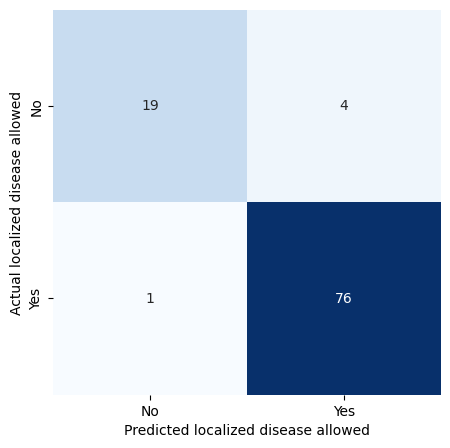

In [13]:
# Create confusion matrix of predicted and actual values for LOCAL
confusion_matrix = pd.crosstab(df_test["LOCAL"], df_test["LOCAL_PREDICTED_ML"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted localized disease allowed")
plt.ylabel("Actual localized disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/confusion_matrix_local_ML.png", dpi=300, bbox_inches="tight")

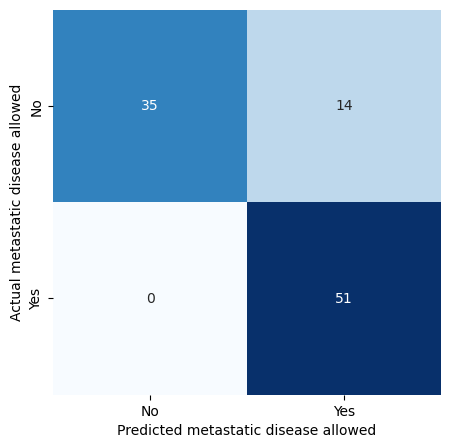

In [14]:
# Create confusion matrix of predicted and actual values for METASTATIC
confusion_matrix = pd.crosstab(df_test["METASTATIC"], df_test["METASTATIC_PREDICTED_ML"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted metastatic disease allowed")
plt.ylabel("Actual metastatic disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/confusion_matrix_metastatic_ML.png", dpi=300, bbox_inches="tight")

### Regex predictions

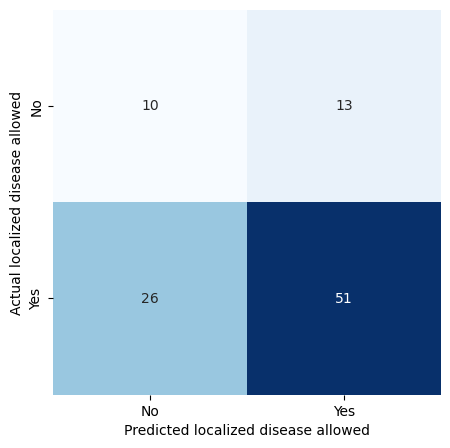

In [15]:
# Create confusion matrix of predicted and actual values for LOCAL using regex
confusion_matrix = pd.crosstab(df_test["LOCAL"], df_test["LOCAL_PREDICTED_REGEX"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted localized disease allowed")
plt.ylabel("Actual localized disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/confusion_matrix_local_regex.png", dpi=300, bbox_inches="tight")

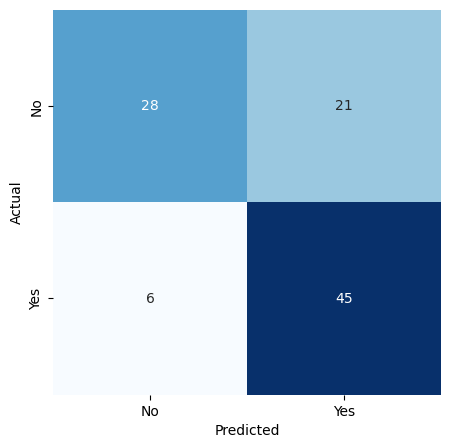

In [16]:
# Create confusion matrix of predicted and actual values for METASTATIC using regex
confusion_matrix = pd.crosstab(df_test["METASTATIC"], df_test["METASTATIC_PREDICTED_REGEX"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/confusion_matrix_metastatic_regex.png", dpi=300, bbox_inches="tight")

### Combined predictions

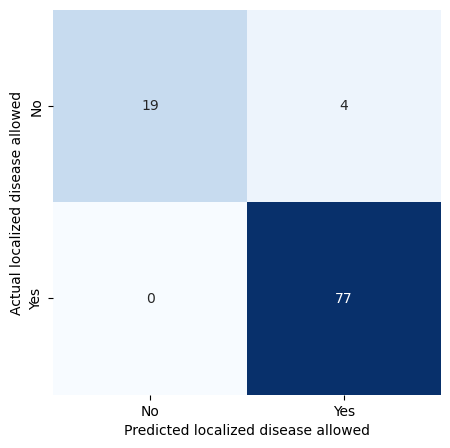

In [17]:
# Create confusion matrix of predicted and actual values for LOCAL using combined method
confusion_matrix = pd.crosstab(df_test["LOCAL"], df_test["LOCAL_PREDICTED_COMBINED"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted localized disease allowed")
plt.ylabel("Actual localized disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/confusion_matrix_local_combined.png", dpi=300, bbox_inches="tight")

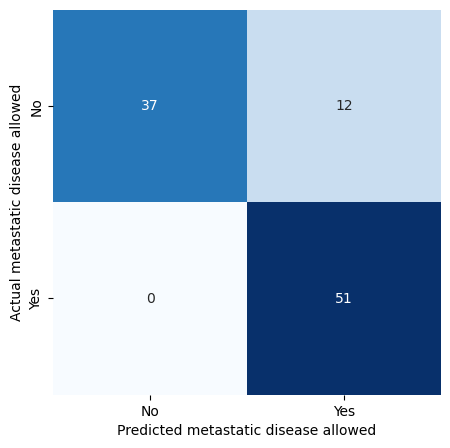

In [19]:
# Create confusion matrix of predicted and actual values for METASTATIC using combined method
confusion_matrix = pd.crosstab(df_test["METASTATIC"], df_test["METASTATIC_PREDICTED_COMBINED"])

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted metastatic disease allowed")
plt.ylabel("Actual metastatic disease allowed")
plt.xticks([0.5, 1.5], ["No", "Yes"])
plt.yticks([0.5, 1.5], ["No", "Yes"])
# Remove the colorbar but keep the width of the heatmap
plt.gca().collections[0].colorbar.remove()
plt.show()
fig.savefig("plots/confusion_matrix_metastatic_combined.png", dpi=300, bbox_inches="tight")
